In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib

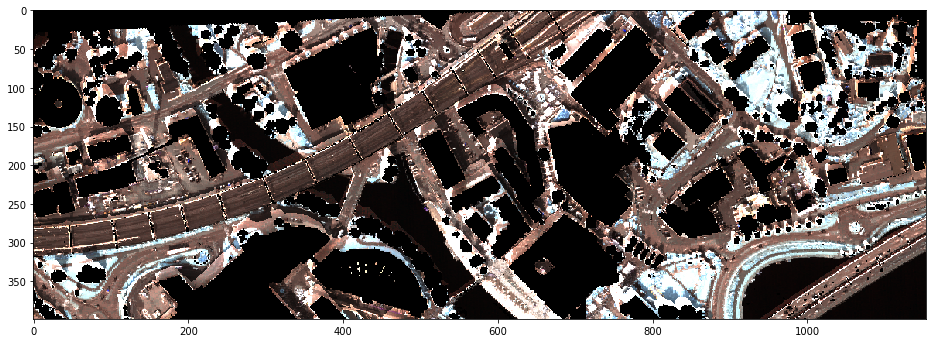

In [2]:
image = envi.open('../../hyperImage/reflectance/swir/training/09_SWIR_MASKED.hdr', 
                  '../../hyperImage/reflectance/swir/training/09_SWIR_MASKED.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [3]:
image.shape

(399, 1154, 288)

In [4]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(399, 1154, 67)

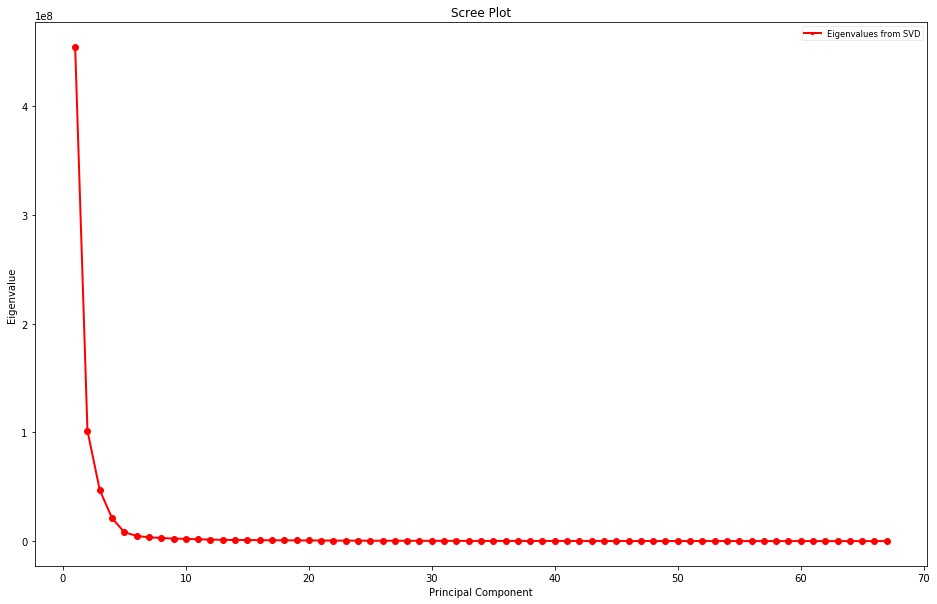

In [5]:
eigvals = pc_0999.eigenvalues
num_vars = 67


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [6]:
pc_img = img_pc.load()
pc_img = pc_img[:,:, :5]
pc_img.shape

(399, 1154, 5)

In [7]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df = pd.concat([df_pca], axis=1, sort=False)

In [8]:
main_df.to_csv('../../hyperImage/csv/features/SWIR_HSI_feature', index=False)

In [ ]:
main_df = pd.read_csv('../../hyperImage/csv/features/SWIR_HSI_feature')

In [ ]:
main_df

In [9]:
## Class image
gt_data = Image.open('../../hyperImage/reflectance/swir/class.tif')
gt = np.array(gt_data)
gt.shape

(399, 1154)

In [10]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [11]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

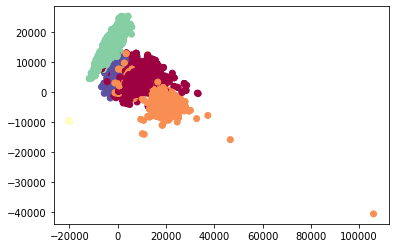

In [12]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [13]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [15]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9775670675300647

In [16]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.96      0.96      0.96      1205
           2       1.00      0.99      1.00       350
           3       1.00      1.00      1.00      1546
           4       1.00      1.00      1.00       994
           5       0.80      0.82      0.81       229

    accuracy                           0.98      4324
   macro avg       0.95      0.95      0.95      4324
weighted avg       0.98      0.98      0.98      4324



In [17]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=4, n_jobs= -1)
random_forest.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [18]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [19]:
y_pred = random_forest.predict(X_data_scaled)

In [20]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

In [21]:
road = (predicted_hsi_mask == 1).astype(int)

In [22]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2057.0]
    G: [0.0, 2904.0]
    B: [0.0, 3236.0]
>

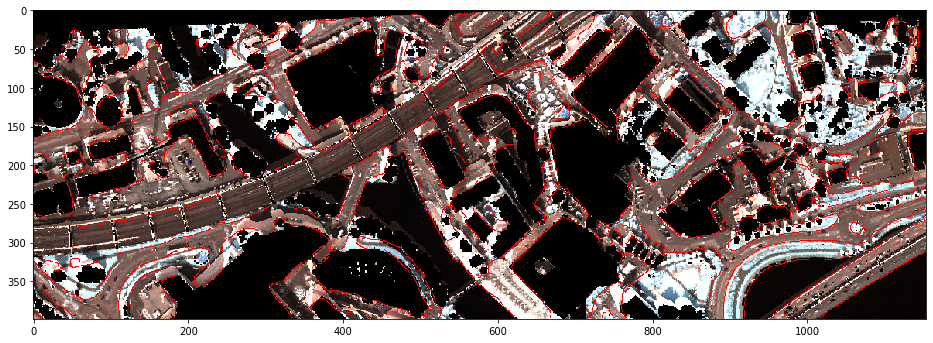

In [23]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2057.0]
    G: [0.0, 2904.0]
    B: [0.0, 3236.0]
>

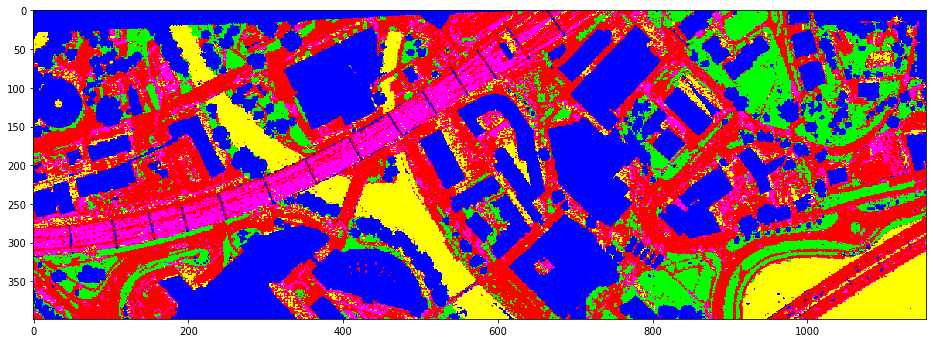

In [24]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [25]:
val_image = envi.open('../../hyperImage/reflectance/swir/08_clipped_road.hdr', '../../hyperImage/reflectance/swir/08_clipped_road.')
val_img = val_image.load()
val_img.shape

(342, 983, 288)

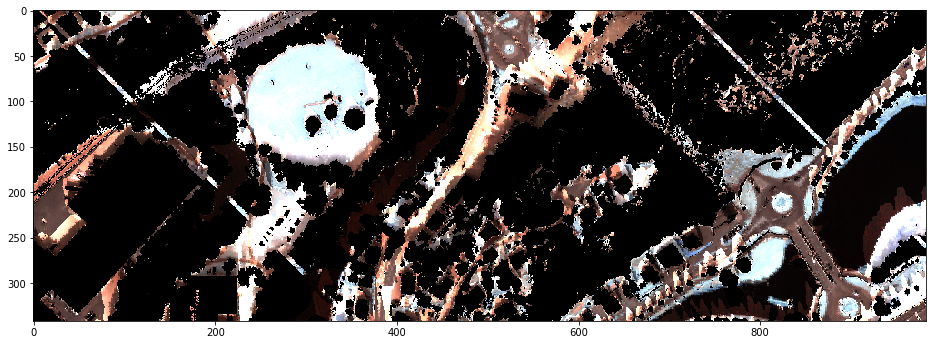

In [26]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [27]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(342, 983, 67)

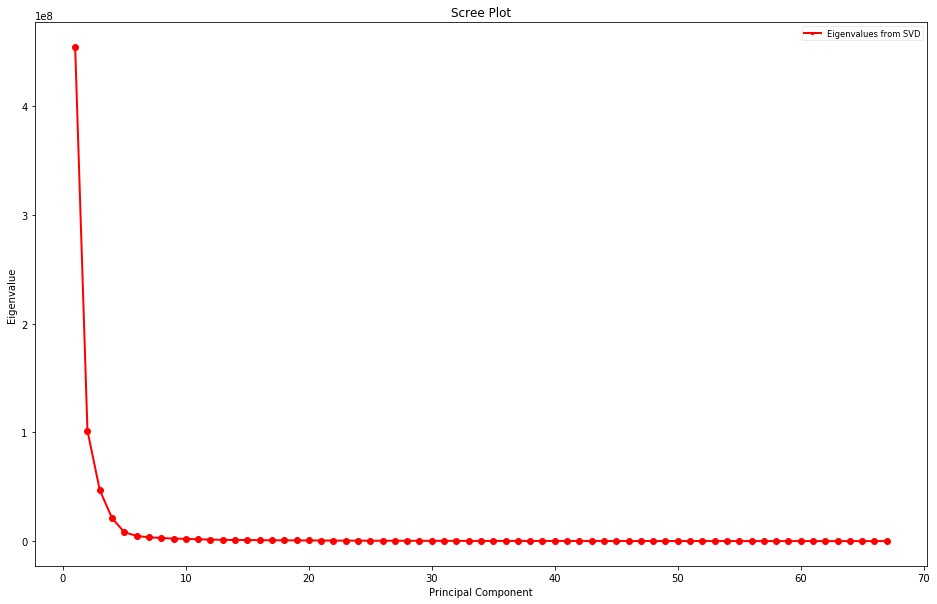

In [29]:
eigvals = pc_0999.eigenvalues
num_vars = 67


fig = plt.figure(figsize=(16, 10))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

In [30]:
pc_img = val_img_pc.load()
pc_img = pc_img[:,:, :5]
pc_img.shape

(342, 983, 5)

In [31]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df_val = pd.concat([df_pca], axis=1, sort=False)

In [32]:
main_df_val.to_csv('../../hyperImage/csv/features/SWIR_HSI_feature_val', index=False)

In [ ]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/SWIR_HSI_feature_val')

In [33]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(342, 983)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [14.0, 4377.0]
    G: [24.0, 5432.0]
    B: [22.0, 5639.0]
>

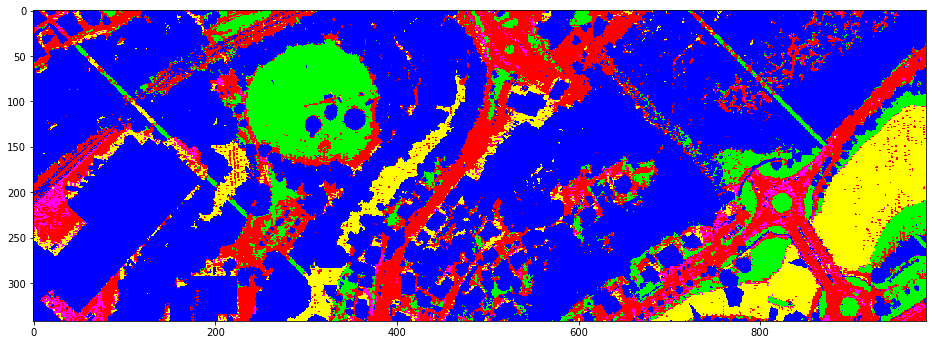

In [34]:
val_full_image = envi.open('../../hyperImage/reflectance/swir/08_cliped.hdr', '../../hyperImage/reflectance/swir/08_cliped.')
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [35]:
## Class image
gt_data_val = Image.open('../../hyperImage/reflectance/swir/swir_class_val.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(342, 983)

In [36]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(336186, 1)

In [37]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [38]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [39]:
accuracy_score(y_val, y_pred)

0.9482554701360142

In [40]:
target_names = ['Road', 'Vegetation', 'Unclassified','Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.96      0.89      0.92      5065
  Vegetation       0.97      0.98      0.98      6240
Unclassified       0.96      1.00      0.98      7831
       Water       0.99      0.92      0.96      4293
 Train Track       0.03      0.07      0.04       245

    accuracy                           0.95     23674
   macro avg       0.78      0.77      0.78     23674
weighted avg       0.96      0.95      0.95     23674



In [41]:
cohen_kappa_score(y_val, y_pred)

0.930322472598587

In [42]:
confusion_matrix(y_val, y_pred)

array([[4493,   25,   21,   27,  499],
       [  76, 6139,   25,    0,    0],
       [   0,    0, 7831,    0,    0],
       [  90,    0,  233, 3970,    0],
       [  44,  177,    8,    0,   16]])

# Using Lidar Data Only

In [43]:
import time
import os
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import math

In [44]:
nDSM = pd.read_csv("../../hyperImage/reflectance/swir/training/swir_nDSM.xyz", delimiter=' ', header=None,
                          names=['X', 'Y', 'Z'])



In [45]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/reflectance/swir/training/swir_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

In [46]:
point_cloud =  pd.concat([nDSM, df_intensity], axis=1, sort=False)

In [47]:
point_cloud

,X,Y,Z,Lidar Intensity
0,584865.949637,6.640449e+06,-3.402823e+38,-9999.0
1,584866.648510,6.640449e+06,-3.402823e+38,-9999.0
2,584867.347383,6.640449e+06,-3.402823e+38,-9999.0
3,584868.046256,6.640449e+06,-3.402823e+38,-9999.0
4,584868.745129,6.640449e+06,-3.402823e+38,-9999.0
...,...,...,...,...
460441,585668.954871,6.640172e+06,0.000000e+00,20.0
460442,585669.653744,6.640172e+06,0.000000e+00,23.0
460443,585670.352617,6.640172e+06,2.000000e-02,12.0
460444,585671.051490,6.640172e+06,2.000000e-02,15.0


In [48]:
points = point_cloud[['X', 'Y', 'Z']]
points = points.values

In [49]:
neighbours = [50]
kdtree = KDTree(points)



In [50]:
distances, point_neighbours = kdtree.query(points, max(neighbours))

KeyboardInterrupt: 

In [ ]:
features = ['delta_z', 'std_z', 'radius', 'density', 'norm_z',
            'linearity', 'planarity', 'sphericity', 'omnivariance',
            'anisotropy', 'eigenentropy', 'sum_eigenvalues',
            'curvature']
feature_values = {}

In [ ]:
def structure_tensor(points):
    """
    Computes the structure tensor of points by computing the eigenvalues
    and eigenvectors of the covariance matrix of a point cloud.
    Parameters
    ----------
    points : (Mx3) array
        X, Y and Z coordinates of points.
    Returns
    -------
    eigenvalues : (1x3) array
        The eigenvalues corrisponding to the eigenvectors of the covariance
        matrix.
    eigenvectors : (3,3) array
        The eigenvectors of the covariance matrix.
    """
    if len(points) > 3:
        cov_mat = np.cov(points, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
        order = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[order]
        eigenvectors = eigenvectors[:, order]
        return eigenvalues, eigenvectors
    else:
        raise ValueError('Not enough points to compute eigenvalues/vectors.')

In [ ]:
def neighbourhood_features(points, point_neighbours, features, distances=None):
    """
    Computes neighbourhood features of a point.
    Height difference (delta z)
    Height standart deviation
    Radius
    Density
    Normal vector (X, Y, Z)
    Linearity:
        L_λ = (λ_1 - λ_2) / λ_1
    Planarity:
        P_λ = (λ_2 − λ_3) / λ_1
    Sphericity:
        S_λ = λ_3 / λ_1
    Omnivariance:
        O_λ = ³√(λ_1 * λ_2 * λ_3)
    Anisotropy:
        A_λ = (λ_1 − λ_3) / λ_1
    Eigenentropy:
        E_λ = −1 * sum[i=1 to 3](λ_i * ln(λ_i))
    Sum of λs:
        Σλ = λ_1 + λ_2 + λ_3
    Change of curvature:
        C_λ = λ_3 / (λ_1 + λ_2 + λ_3)
    (Blomley, Weimann, Leitloff and Jutzi, 2014)
    Roughness:
        Distance between point and best fit plane
    Parameters
    ----------
    points : (Mx3) array
        X, Y and Z coordinates of points.
    point_neighbours : array
        The indices of the neighbouring points of each point.
    features : list of strings
        The features to be calculated. Possible features: 'delta_z', 'std_z',
        'radius', 'density', 'linearity', 'planarity', 'sphericity',
        'omnivariance', 'anisotropy', 'eigenentropy', 'sum_eigenvalues',
        'curvature', 'roughness', 'norm_x', 'norm_y', 'norm_z'
    distances : array
        The distances between the point and the neighbouring points. Needed
        for the computation of 'radius' and 'density'.
    Returns
    -------
    feature_values : array
        The computed values for each of the features specified. For each
        feature a column.
    """
    pca_features = ['linearity', 'planarity', 'sphericity', 'omnivariance',
                    'anisotropy', 'eigenentropy', 'sum_eigenvalues',
                    'curvature', 'verticality', 'norm_x', 'norm_y', 'norm_z']
    n_points = len(points)

    if any(i in pca_features for i in features):
        eigenvalues = np.zeros((n_points, 3))
        normal_vectors = np.zeros((n_points, 3))

    if 'delta_z' in features:
        delta_z = np.zeros(n_points)
    if 'std_z' in features:
        std_z = np.zeros(n_points)
    if 'radius'in features:
        if distances is None:
            raise ValueError('No distances given.')
        radius = np.zeros(n_points)
    if 'density' in features:
        if distances is None:
            raise ValueError('No distances given.')
        density = np.zeros(n_points)
    if 'roughness' in features:
        roughness = np.zeros(n_points)

    for i in range(n_points):
        local_points = points[point_neighbours[i]]

        if len(local_points) > 3:
            if any(i in pca_features for i in features):
                evalues, evectors = structure_tensor(local_points)
                eigenvalues[i, :] = evalues
                normal_vector = evectors[:, 2]
                normal_vectors[i, :] = normal_vector

            if 'delta_z' in features:
                delta_z[i] = max(local_points[:, 2]) - min(local_points[:, 2])
            if 'std_z' in features:
                std_z[i] = np.std(local_points[:, 2])
            if 'radius'in features:
                radius[i] = max(distances[i])
            if 'density' in features:
                density[i] = len(local_points) / ((4/3) * math.pi *
                                                  max(distances[i])**3)
            if 'roughness' in features:
                mean_point = np.mean(local_points, axis=0)
                a, b, c = normal_vector[0], normal_vector[1], normal_vector[2]
                d = -(np.dot(normal_vector, mean_point))
                dist = abs((a * points[i][0] + b * points[i][1] +
                            c * points[i][2] + d) /
                           (math.sqrt(a**2 + b**2 + c**2)))
                roughness[i] = dist
        else:
            if any(i in pca_features for i in features):
                eigenvalues[i, :] = [float('nan'), float('nan'), float('nan')]
                normal_vectors[i, :] = [float('nan'), float('nan'), float('nan')]
            if 'roughness' in features:
                roughness[i] = float('nan')
    if any(i in pca_features for i in features):
        sum_eigenvalues = np.sum(eigenvalues, axis=1)
        eigenvalues = (eigenvalues /
                       np.tile(np.array([sum_eigenvalues]).transpose(), (1, 3)))

    feature_values = np.zeros((n_points, len(features)))
    for i, f in enumerate(features):
        if f == 'linearity':
            feature_values[:, i] = ((eigenvalues[:, 0] - eigenvalues[:, 1]) /
                                    eigenvalues[:, 0])
        elif f == 'planarity':
            feature_values[:, i] = ((eigenvalues[:, 1] - eigenvalues[:, 2]) /
                                    eigenvalues[:, 0])
        elif f == 'sphericity':
            feature_values[:, i] = eigenvalues[:, 2] / eigenvalues[:, 0]
        elif f == 'omnivariance':
            feature_values[:, i] = (eigenvalues[:, 0] * eigenvalues[:, 1] *
                                    eigenvalues[:, 2]) ** (1./3.)
        elif f == 'anisotropy':
            feature_values[:, i] = ((eigenvalues[:, 0] - eigenvalues[:, 2]) /
                                    eigenvalues[:, 0])
        elif f == 'eigenentropy':
            feature_values[:, i] = (-1 *
                                    ((eigenvalues[:, 0] * np.log(eigenvalues[:, 0])) +
                                     (eigenvalues[:, 1] * np.log(eigenvalues[:, 1])) +
                                     (eigenvalues[:, 2] * np.log(eigenvalues[:, 2]))))
        elif f == 'sum_eigenvalues':
            feature_values[:, i] = sum_eigenvalues
        elif f == 'curvature':
            feature_values[:, i] = eigenvalues[:, 2] / sum_eigenvalues
        elif f == 'roughness':
            feature_values[:, i] = roughness
        elif f == 'norm_x':
            feature_values[:, i] = normal_vectors[:, 0]
        elif f == 'norm_y':
            feature_values[:, i] = normal_vectors[:, 1]
        elif f == 'norm_z':
            feature_values[:, i] = abs(normal_vectors[:, 2])
        elif f == 'delta_z':
            feature_values[:, i] = delta_z
        elif f == 'std_z':
            feature_values[:, i] = std_z
        elif f == 'radius':
            feature_values[:, i] = radius
        elif f == 'density':
            feature_values[:, i] = density
        else:
            raise ValueError('Inavailable features.')

    return feature_values

In [ ]:
for k in neighbours:
    t = time.time()
    fv = neighbourhood_features(points, point_neighbours[:, :k],
                                features, distances[:, :k])
    feature_values[k] = fv

In [ ]:
for k in neighbours:
    for i, f in enumerate(features):
        key = f + '_' + str(k)
        point_cloud[key] = pd.Series(feature_values[k][:, i])

In [ ]:
point_cloud.to_csv('../../hyperImage/csv/features/SWIR_lidar_features', index=False)

In [51]:
point_cloud = pd.read_csv('../../hyperImage/csv/features/SWIR_lidar_features')

In [52]:
point_cloud

,X,Y,Z,Lidar Intensity,delta_z_50,std_z_50,radius_50,density_50,norm_z_50,linearity_50,planarity_50,sphericity_50,omnivariance_50,anisotropy_50,eigenentropy_50,sum_eigenvalues_50,curvature_50
0,584865.949637,6.640449e+06,-3.402823e+38,-9999.0,0.00,0.000000,5.029937,0.093798,1.000000,0.439365,0.560635,0.000000,0.000000,1.000000,NaN,4.328694,0.000000
1,584866.648510,6.640449e+06,-3.402823e+38,-9999.0,0.00,0.000000,4.682315,0.116279,1.000000,0.389449,0.610551,0.000000,0.000000,1.000000,NaN,4.171507,0.000000
2,584867.347383,6.640449e+06,-3.402823e+38,-9999.0,0.00,0.000000,4.250361,0.155455,1.000000,0.504315,0.495685,0.000000,0.000000,1.000000,NaN,4.369567,0.000000
3,584868.046256,6.640449e+06,-3.402823e+38,-9999.0,0.00,0.000000,4.056309,0.178850,1.000000,0.554132,0.445868,0.000000,0.000000,1.000000,NaN,4.368396,0.000000
4,584868.745129,6.640449e+06,-3.402823e+38,-9999.0,0.00,0.000000,3.743197,0.227590,1.000000,0.609887,0.390113,0.000000,0.000000,1.000000,NaN,4.536206,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460441,585668.954871,6.640172e+06,0.000000e+00,20.0,0.07,0.020947,3.743411,0.227551,0.999996,0.609889,0.389981,0.000130,0.026628,0.999870,0.594456,4.536654,0.000021
460442,585669.653744,6.640172e+06,0.000000e+00,23.0,0.07,0.020846,4.056506,0.178824,0.999995,0.554136,0.445726,0.000138,0.027285,0.999862,0.618710,4.368840,0.000022
460443,585670.352617,6.640172e+06,2.000000e-02,12.0,0.07,0.021844,4.250408,0.155450,0.999992,0.504315,0.495530,0.000154,0.028387,0.999846,0.636158,4.370054,0.000024
460444,585671.051490,6.640172e+06,2.000000e-02,15.0,0.07,0.022117,4.682357,0.116275,0.999990,0.389438,0.610382,0.000180,0.029720,0.999820,0.664674,4.172007,0.000027


In [53]:
point_cloud = pd.concat([point_cloud, df_class], axis=1, sort=False)

In [54]:
point_cloud = point_cloud.drop(['eigenentropy_50'], axis=1)
point_cloud.isnull().sum()


X                     0
Y                     0
Z                     0
Lidar Intensity       0
delta_z_50            0
std_z_50              0
radius_50             0
density_50            0
norm_z_50             0
linearity_50          0
planarity_50          0
sphericity_50         0
omnivariance_50       0
anisotropy_50         0
sum_eigenvalues_50    0
curvature_50          0
Target                0
dtype: int64

In [55]:
df_masked =  point_cloud[(point_cloud[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target', 'X', 'Y']).values
y = df_masked['Target'].values

In [56]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9259944495837188

In [58]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [59]:
X_data = point_cloud.drop(columns=['Target', 'X', 'Y']).values
X_data_scaled = scaler1.transform(X_data)

In [60]:
y_pred = random_forest3.predict(X_data_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2057.0]
    G: [0.0, 2904.0]
    B: [0.0, 3236.0]
>

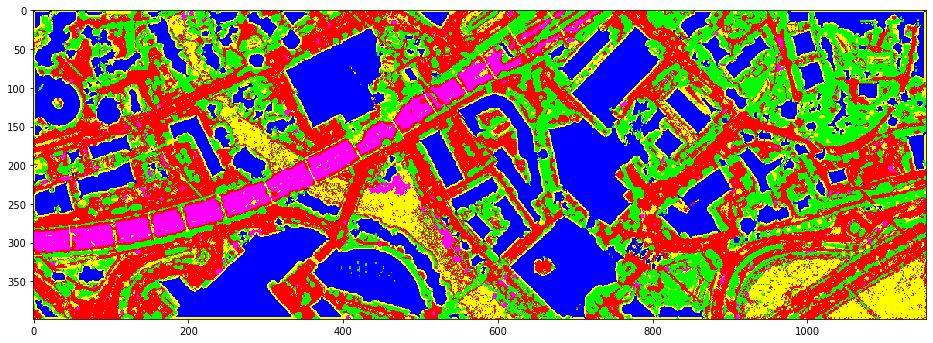

In [61]:
predicted_lidar_mask = y_pred.reshape(399, 1154)
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [62]:
road = (predicted_lidar_mask == 1).astype(int)

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2057.0]
    G: [0.0, 2904.0]
    B: [0.0, 3236.0]
>

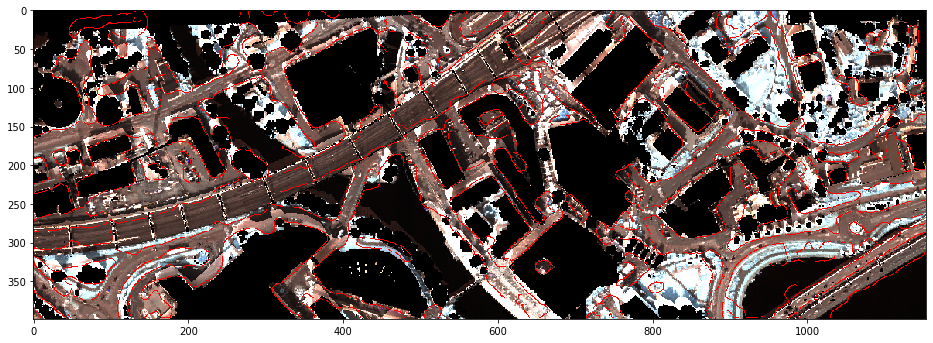

In [64]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [63]:
nDSM = pd.read_csv("../../hyperImage/reflectance/swir/validation/nDSM_masked.xyz", delimiter=' ', header=None,
                          names=['X', 'Y', 'Z'])



In [ ]:
l_intensity_data = Image.open('../../hyperImage/reflectance/swir/validation/intensity_masked.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

In [ ]:
point_cloud_val =  pd.concat([nDSM, df_intensity], axis=1, sort=False)
point_cloud_val

In [ ]:
points = point_cloud[['X', 'Y', 'Z']]
points = points.values

In [ ]:
neighbours = [50]
kdtree = KDTree(points)

In [ ]:
distances, point_neighbours = kdtree.query(points, max(neighbours))

In [ ]:
features = ['delta_z', 'std_z', 'radius', 'density', 'norm_z',
            'linearity', 'planarity', 'sphericity', 'omnivariance',
            'anisotropy', 'eigenentropy', 'sum_eigenvalues',
            'curvature']
feature_values = {}

In [ ]:
for k in neighbours:
    t = time.time()
    fv = neighbourhood_features(points, point_neighbours[:, :k],
                                features, distances[:, :k])
    feature_values[k] = fv

In [ ]:
for k in neighbours:
    for i, f in enumerate(features):
        key = f + '_' + str(k)
        point_cloud_val[key] = pd.Series(feature_values[k][:, i])

In [ ]:
point_cloud_val.to_csv('../../hyperImage/csv/features/SWIR_lidar_features_val', index=False)

In [65]:
point_cloud_val = pd.read_csv('../../hyperImage/csv/features/SWIR_lidar_features_val')

In [66]:
point_cloud_val = point_cloud_val.drop(columns=['eigenentropy_50', 'X', 'Y'])
X_data_val_scaled = scaler1.transform(point_cloud_val.values)
y_pred = random_forest3.predict(X_data_val_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [14.0, 4377.0]
    G: [24.0, 5432.0]
    B: [22.0, 5639.0]
>

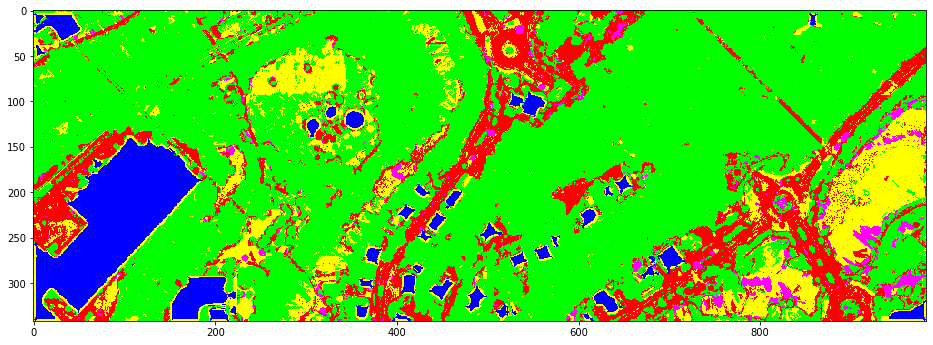

In [67]:
predicted_lidar_mask = y_pred.reshape(342, 983)
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [68]:
df_lidar_val = pd.concat([point_cloud_val, df_class_val], axis=1, sort=False)
df_lidar_val

,Z,Lidar Intensity,delta_z_50,std_z_50,radius_50,density_50,norm_z_50,linearity_50,planarity_50,sphericity_50,omnivariance_50,anisotropy_50,sum_eigenvalues_50,curvature_50,Target
0,29.959999,16.0,7.35,2.163218,13.131387,0.005272,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
1,29.940001,15.0,7.35,2.163218,12.683699,0.005850,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
2,29.940001,16.0,7.35,2.163218,12.271479,0.006459,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
3,29.910000,19.0,7.43,2.333557,11.947026,0.007000,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,28.408422,0.001894,0
4,29.920000,17.0,7.43,2.333557,11.587792,0.007671,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,28.408422,0.001894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,-9999.000000,-9999.0,0.00,0.000000,3.770897,0.222611,1.000000,0.653776,0.346224,0.000000,0.000000,1.000000,4.681219,0.000000,0
336182,-9999.000000,-9999.0,0.00,0.000000,4.082763,0.175396,1.000000,0.590366,0.409634,0.000000,0.000000,1.000000,4.465221,0.000000,0
336183,-9999.000000,-9999.0,0.00,0.000000,4.259648,0.154440,1.000000,0.499655,0.500345,0.000000,0.000000,1.000000,4.405640,0.000000,0
336184,-9999.000000,-9999.0,0.00,0.000000,4.697176,0.115178,1.000000,0.384972,0.615028,0.000000,0.000000,1.000000,4.208850,0.000000,0


In [69]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [70]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [71]:
accuracy_score(y_val, y_pred)

0.6332263242375602

In [72]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.88      0.82      0.85      5065
  Vegetation       0.43      0.45      0.44      6240
Unclassified       0.99      0.57      0.73      7831
       Water       0.50      0.82      0.62      4293
 Train Track       0.00      0.01      0.01       245

    accuracy                           0.63     23674
   macro avg       0.56      0.54      0.53     23674
weighted avg       0.72      0.63      0.65     23674



In [73]:
confusion_matrix(y_val, y_pred)

array([[4163,  149,    0,  567,  186],
       [ 184, 2819,    0, 2958,  279],
       [  13, 3320, 4480,   18,    0],
       [ 297,  195,    0, 3526,  275],
       [  72,  117,   39,   14,    3]])

In [74]:
cohen_kappa_score(y_val, y_pred)

0.521220226059719

# Using  hyperspectral and lidar data 

# Training

In [75]:
df_lid_hsi = pd.concat([main_df,point_cloud], axis=1, sort=False)

In [76]:
df_lid_hsi.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'X', 'Y', 'Z', 'Lidar Intensity',
       'delta_z_50', 'std_z_50', 'radius_50', 'density_50', 'norm_z_50',
       'linearity_50', 'planarity_50', 'sphericity_50', 'omnivariance_50',
       'anisotropy_50', 'sum_eigenvalues_50', 'curvature_50', 'Target'],
      dtype='object')

In [77]:
df_lidar_hsi = df_lid_hsi.drop(['X', 'Y'], axis=1)

In [78]:
df_lidar_hsi.isnull().sum()

PC1                   0
PC2                   0
PC3                   0
PC4                   0
PC5                   0
Z                     0
Lidar Intensity       0
delta_z_50            0
std_z_50              0
radius_50             0
density_50            0
norm_z_50             0
linearity_50          0
planarity_50          0
sphericity_50         0
omnivariance_50       0
anisotropy_50         0
sum_eigenvalues_50    0
curvature_50          0
Target                0
dtype: int64

In [79]:
df_masked =  df_lidar_hsi[(df_lidar_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [80]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)


In [82]:
accuracy_score(y_test, pred)

0.9979185938945421

In [83]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [84]:
X_data = df_lidar_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [85]:
y_pred = random_forest3.predict(X_data_scaled)

In [86]:
predicted_hsi_lidar_mask = y_pred.reshape(399, 1154)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2057.0]
    G: [0.0, 2904.0]
    B: [0.0, 3236.0]
>

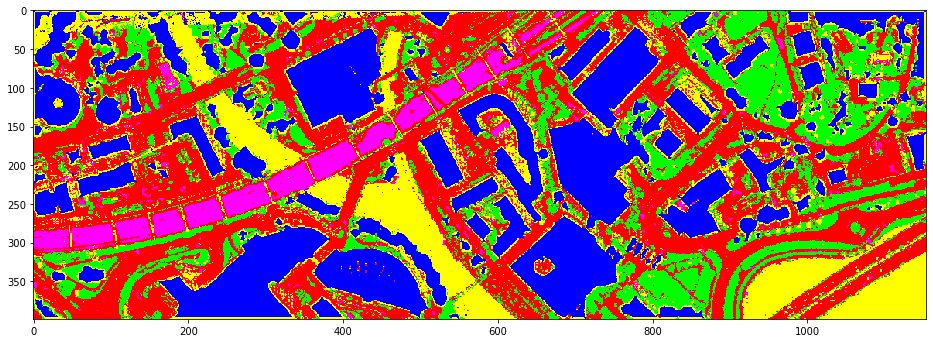

In [87]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [88]:
main_df = pd.read_csv('../../hyperImage/csv/features/SWIR_HSI_feature_val')

In [89]:
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/SWIR_lidar_features_val')

In [90]:
df_lid_hsi = pd.concat([main_df, point_cloud_val], axis=1, sort=False)
df_lid_hsi

,PC1,PC2,PC3,PC4,PC5,X,Y,Z,Lidar Intensity,delta_z_50,...,density_50,norm_z_50,linearity_50,planarity_50,sphericity_50,omnivariance_50,anisotropy_50,eigenentropy_50,sum_eigenvalues_50,curvature_50
0,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,584802.349949,6.640792e+06,29.959999,16.0,7.35,...,0.005272,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,0.841151,28.009288,0.001885
1,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,584803.049847,6.640792e+06,29.940001,15.0,7.35,...,0.005850,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,0.841151,28.009288,0.001885
2,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,584803.749746,6.640792e+06,29.940001,16.0,7.35,...,0.006459,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,0.841151,28.009288,0.001885
3,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,584804.449644,6.640792e+06,29.910000,19.0,7.43,...,0.007000,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,0.837065,28.408422,0.001894
4,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,584805.149542,6.640792e+06,29.920000,17.0,7.43,...,0.007671,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,0.837065,28.408422,0.001894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,4787.334161,5020.175632,77.617424,-4659.799523,-2919.086760,585486.850458,6.640553e+06,-9999.000000,-9999.0,0.00,...,0.222611,1.000000,0.653776,0.346224,0.000000,0.000000,1.000000,NaN,4.681219,0.000000
336182,3475.501014,3806.821770,497.747763,-4523.871264,-1261.661106,585487.550356,6.640553e+06,-9999.000000,-9999.0,0.00,...,0.175396,1.000000,0.590366,0.409634,0.000000,0.000000,1.000000,NaN,4.465221,0.000000
336183,-356.801732,7227.762309,-1194.351369,-6833.871171,3074.961350,585488.250254,6.640553e+06,-9999.000000,-9999.0,0.00,...,0.154440,1.000000,0.499655,0.500345,0.000000,0.000000,1.000000,NaN,4.405640,0.000000
336184,-10.994249,7942.657096,-1486.241217,-6511.888027,734.734196,585488.950153,6.640553e+06,-9999.000000,-9999.0,0.00,...,0.115178,1.000000,0.384972,0.615028,0.000000,0.000000,1.000000,NaN,4.208850,0.000000


In [91]:
df_lid_hsi.isnull().sum()

PC1                       0
PC2                       0
PC3                       0
PC4                       0
PC5                       0
X                         0
Y                         0
Z                         0
Lidar Intensity           0
delta_z_50                0
std_z_50                  0
radius_50                 0
density_50                0
norm_z_50                 0
linearity_50              0
planarity_50              0
sphericity_50             0
omnivariance_50           0
anisotropy_50             0
eigenentropy_50       34034
sum_eigenvalues_50        0
curvature_50              0
dtype: int64

In [92]:
df_lid_his_ = df_lid_hsi.drop(columns=['eigenentropy_50', 'X', 'Y'])
X_data_scaled = scaler3.transform(df_lid_his_)

In [93]:
val_pred_full = random_forest3.predict(X_data_scaled)

In [94]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [14.0, 4377.0]
    G: [24.0, 5432.0]
    B: [22.0, 5639.0]
>

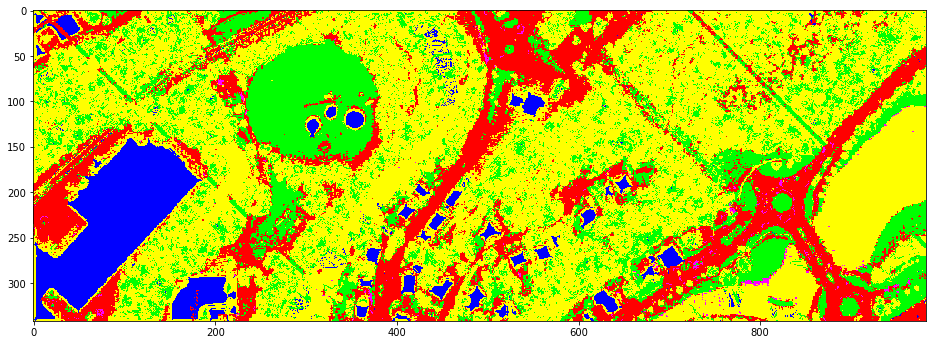

In [95]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [96]:
df_val = pd.concat([df_lid_his_, df_class_val], axis=1, sort=False)

In [97]:
df_val

,PC1,PC2,PC3,PC4,PC5,Z,Lidar Intensity,delta_z_50,std_z_50,radius_50,density_50,norm_z_50,linearity_50,planarity_50,sphericity_50,omnivariance_50,anisotropy_50,sum_eigenvalues_50,curvature_50,Target
0,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,29.959999,16.0,7.35,2.163218,13.131387,0.005272,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
1,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,29.940001,15.0,7.35,2.163218,12.683699,0.005850,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
2,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,29.940001,16.0,7.35,2.163218,12.271479,0.006459,0.847234,0.353858,0.554398,0.091744,0.224361,0.908256,28.009288,0.001885,0
3,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,29.910000,19.0,7.43,2.333557,11.947026,0.007000,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,28.408422,0.001894,0
4,-20125.354164,-9575.868713,1345.850227,837.976711,-309.635477,29.920000,17.0,7.43,2.333557,11.587792,0.007671,0.834671,0.391882,0.516655,0.091463,0.224596,0.908537,28.408422,0.001894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,4787.334161,5020.175632,77.617424,-4659.799523,-2919.086760,-9999.000000,-9999.0,0.00,0.000000,3.770897,0.222611,1.000000,0.653776,0.346224,0.000000,0.000000,1.000000,4.681219,0.000000,0
336182,3475.501014,3806.821770,497.747763,-4523.871264,-1261.661106,-9999.000000,-9999.0,0.00,0.000000,4.082763,0.175396,1.000000,0.590366,0.409634,0.000000,0.000000,1.000000,4.465221,0.000000,0
336183,-356.801732,7227.762309,-1194.351369,-6833.871171,3074.961350,-9999.000000,-9999.0,0.00,0.000000,4.259648,0.154440,1.000000,0.499655,0.500345,0.000000,0.000000,1.000000,4.405640,0.000000,0
336184,-10.994249,7942.657096,-1486.241217,-6511.888027,734.734196,-9999.000000,-9999.0,0.00,0.000000,4.697176,0.115178,1.000000,0.384972,0.615028,0.000000,0.000000,1.000000,4.208850,0.000000,0


In [98]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values

In [99]:
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [100]:
accuracy_score(y_val, val_pred_full_)

0.8297288164230802

In [101]:
target_names = ['Road', 'Vegetation', 'Soil','Train Track', 'Pavement', 'Water', 'Unclassified']
print(classification_report(y_val, val_pred_full_, target_names=target_names))

ValueError: Number of classes, 5, does not match size of target_names, 7. Try specifying the labels parameter

In [102]:
confusion_matrix(y_val, val_pred_full_)

array([[4858,   33,    0,   33,  141],
       [  85, 6135,    0,   20,    0],
       [   1,  742, 4487, 2601,    0],
       [   7,   41,   66, 4163,   16],
       [  59,  178,    1,    7,    0]])

In [103]:
cohen_kappa_score(y_val, val_pred_full_)

0.7757763599435571